In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

# Imports

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback 
from torch_geometric.data import DataLoader
from rdkit import Chem


from src import models
from src import experimental_setup
experimental_setup.path_prefix = '/../'

# Experimental setup

In [5]:
_benchmarks = {
    'dnn_mordred': {'model': models.DNN_Mordred, 'encoding': 'mordred'},
    'dnn_ecfp': {'model': models.DNN_ECFP, 'encoding': 'ecfp_2048'},
    'rf_mordred': {'model': models.RF, 'encoding': 'mordred'},
    'rf_ecfp': {'model': models.RF, 'encoding': 'ecfp_4096'},
    'rf_nmf_ecfp': {'model': models.RF_NMF_ECFP, 'encoding': 'ecfp_4096'},
    'gp': {'model': models.GP, 'encoding': 'gp'},
    'gcn': {'model': models.GCN, 'encoding': 'smiles'}
}

# benchmarks to train/validate, check _benchmark_dict for options
run_benchmarks = ['dnn_mordred','dnn_ecfp']

# `random` or `stratified`
sampling_type = 'random'

kfold = experimental_setup.CrossValidator(
    splits = 5, # dont change without re-running data preprocessing
    sampling_type = sampling_type,
)

converter = experimental_setup.LD50UnitConverter()

# Train/predict using benchmark models

In [6]:
import matplotlib.pyplot as plt
loss_histories = {}

for identity in run_benchmarks:
    benchmark = _benchmarks[identity]
    
    folds = enumerate(kfold.get_folds(benchmark['encoding']))
    
    for fold_no, (train, test) in folds:           
        x_train, y_train, smiles_train = train
        x_test, y_test, smiles_test = test
        
        y_train = experimental_setup.scaler.fit_transform(y_train)
        
        model = _benchmarks[identity]['model']()
        
        # <Gaussian process has special step for selecting parameters based on
        # RF benchmark models for ECFP and Mordred
        if identity == 'gp':
            fn = 'rf_mordred' + str(fold_no) + '_' + sampling_type
            mordred_rf = _benchmarks['rf_mordred']['model']()
            mordred_rf.load_weights('../../data/benchmark-models/chkpts/%s.chkpt' % fn)
            
            fn = 'rf_ecfp' + str(fold_no) + '_' + sampling_type
            ecfp_rf = _benchmarks['rf_ecfp']['model']()
            ecfp_rf.load_weights('../../data/benchmark-models/chkpts/%s.chkpt' % fn)
            
            model.rf_feature_selectors = (mordred_rf, ecfp_rf)
            model.rf_feature_reduce_to = (10, 200)
        # End of special GP step>
        
        #Mordred and ECPF Loss: 
        # Mordred and ECFP Loss collection
        if identity == 'dnn_mordred':
            DNN_mordredLosses = model.fit(x_train, y_train)
            loss_histories.setdefault('dnn_mordred', []).append(DNN_mordredLosses)
        
        if identity == 'dnn_ecfp':     
            DNN_ecfpLosses = model.fit(x_train, y_train)
            loss_histories.setdefault('dnn_ecfp', []).append(DNN_ecfpLosses)
               
        #save model
        fn = identity + str(fold_no) + '_' + sampling_type
        model.save_weights('../../data/benchmark-models/chkpts/%s.chkpt' % fn)
        
        y_hat = experimental_setup.scaler.inverse_transform(model.predict(x_test)) 
        
        results = pd.DataFrame({
            'smiles': smiles_test.flatten(),
            'prediction_neglogld50': y_hat.flatten(),
            'prediction_mgkg': converter.convert_to_mgkg(y_hat, smiles_test),
            'prediction_epa': converter.convert_to_epa(y_hat, smiles_test),
            'actual_neglogld50': y_test.flatten(),
            'actual_mgkg': converter.convert_to_mgkg(y_test, smiles_test),
            'actual_epa': converter.convert_to_epa(y_test, smiles_test),
        })
        
        results.to_csv('../../data/benchmark-models/%s_predictions.csv' % fn)

Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn__mordred', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 502216.8750 - mae: 189.2576 - mse: 502216.8750
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2527 - mae: 0.8483 - mse: 1.2527
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9602 - mae: 0.7380 - mse: 0.9602
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9180 - mae: 0.7251 - mse: 0.9180
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9001 - mae: 0.7201 - mse: 0.9001
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8965 - mae: 0.7199 - mse: 0.8965
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8860 - mae: 0.7123 - mse: 0.8860
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8717 - mae: 0.7102 - mse: 0.8717
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8655 - mae: 0.7074 - mse: 0.8655
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8610 - mae: 0.7072 - mse: 0.8610
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn__mordred_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 519617.5000 - mae: 190.1945 - mse: 519617.5000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9727 - mae: 0.7510 - mse: 0.9727
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8987 - mae: 0.7200 - mse: 0.8987
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8858 - mae: 0.7125 - mse: 0.8858
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8844 - mae: 0.7136 - mse: 0.8844
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8754 - mae: 0.7083 - mse: 0.8754
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8662 - mae: 0.7056 - mse: 0.8662
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8650 - mae: 0.7067 - mse: 0.8650
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8615 - mae: 0.7051 - mse: 0.8615
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8578 - mae: 0.7039 - mse: 0.8578
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn__mordred_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1055552.7500 - mae: 228.2735 - mse: 1055552.7500
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3752 - mae: 1.8214 - mse: 7.3752
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4451 - mae: 0.8976 - mse: 1.4451
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5274 - mae: 0.9151 - mse: 1.5274
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4634 - mae: 0.9025 - mse: 1.4634
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3607 - mae: 0.8753 - mse: 1.3607
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3870 - mae: 0.8846 - mse: 1.3870
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1743 - mae: 0.8254 - mse: 1.1743
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1088 - mae: 0.8034 - mse: 1.1088
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1338 - mae: 0.8086 - mse: 1.1338
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn__mordred_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 770770.2500 - mae: 211.2753 - mse: 770770.2500
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2651 - mae: 1.0567 - mse: 2.2651
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0780 - mae: 0.7873 - mse: 1.0780
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0479 - mae: 0.7764 - mse: 1.0479
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0129 - mae: 0.7650 - mse: 1.0129
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9894 - mae: 0.7408 - mse: 0.9894
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9479 - mae: 0.7212 - mse: 0.9479
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8853 - mae: 0.7012 - mse: 0.8853
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8989 - mae: 0.7053 - mse: 0.8989
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8926 - mae: 0.7033 - mse: 0.8926
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn__mordred_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 836974.3750 - mae: 238.4858 - mse: 836974.3750
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0587 - mae: 1.2029 - mse: 3.0587
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2414 - mae: 0.8605 - mse: 1.2414
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0581 - mae: 0.8033 - mse: 1.0581
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0037 - mae: 0.7777 - mse: 1.0037 
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9782 - mae: 0.7652 - mse: 0.9782
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9686 - mae: 0.7584 - mse: 0.9686
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9612 - mae: 0.7532 - mse: 0.9612
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9599 - mae: 0.7504 - mse: 0.9599
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9816 - mae: 0.7546 - mse: 0.9816
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn_ecfp', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.7709 - mae: 0.6604 - mse: 0.7709
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.3842 - mae: 0.4574 - mse: 0.3842
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.2852 - mae: 0.3891 - mse: 0.2852
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.2090 - mae: 0.3263 - mse: 0.2090
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.1508 - mae: 0.2707 - mse: 0.1508
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.1094 - mae: 0.2245 - mse: 0.1094
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0829 - mae: 0.1915 - mse: 0.0829
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0676 - mae: 0.1699 - mse: 0.0676
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0673 - mae: 0.1746 - mse: 0.0673
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.1371 - mae: 0.2907 - mse: 0.1371
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn_ecfp_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.7704 - mae: 0.6662 - mse: 0.7704
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.3804 - mae: 0.4602 - mse: 0.3804
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.2834 - mae: 0.3900 - mse: 0.2834
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.2118 - mae: 0.3329 - mse: 0.2118
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.1576 - mae: 0.2820 - mse: 0.1576
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.1178 - mae: 0.2381 - mse: 0.1178
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0940 - mae: 0.2099 - mse: 0.0940
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0899 - mae: 0.2114 - mse: 0.0899
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.1995 - mae: 0.3604 - mse: 0.1995
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.2334 - mae: 0.3843 - mse: 0.2334
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn_ecfp_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.7325 - mae: 0.6441 - mse: 0.7325
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.3779 - mae: 0.4582 - mse: 0.3779
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.2895 - mae: 0.3989 - mse: 0.2895
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.2281 - mae: 0.3517 - mse: 0.2281
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.2084 - mae: 0.3443 - mse: 0.2084
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.1757 - mae: 0.3181 - mse: 0.1757
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.1225 - mae: 0.2543 - mse: 0.1225
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0897 - mae: 0.2096 - mse: 0.0897
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0819 - mae: 0.2053 - mse: 0.0819
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0789 - mae: 0.2051 - mse: 0.0789
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn_ecfp_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.7269 - mae: 0.6359 - mse: 0.7269
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.3736 - mae: 0.4551 - mse: 0.3736
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.2775 - mae: 0.3859 - mse: 0.2775
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.2055 - mae: 0.3257 - mse: 0.2055
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.1509 - mae: 0.2729 - mse: 0.1509
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.1150 - mae: 0.2323 - mse: 0.1150
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0980 - mae: 0.2158 - mse: 0.0980
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.1199 - mae: 0.2601 - mse: 0.1199
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.1253 - mae: 0.2662 - mse: 0.1253
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.1436 - mae: 0.2943 - mse: 0.1436
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn_ecfp_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.6932 - mae: 0.6301 - mse: 0.6932
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.3689 - mae: 0.4481 - mse: 0.3689
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.2736 - mae: 0.3796 - mse: 0.2736
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.2032 - mae: 0.3224 - mse: 0.2032
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.1473 - mae: 0.2700 - mse: 0.1473
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.1067 - mae: 0.2243 - mse: 0.1067
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0818 - mae: 0.1925 - mse: 0.0818
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0702 - mae: 0.1815 - mse: 0.0702
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.1160 - mae: 0.2653 - mse: 0.1160
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.1171 - mae: 0.2584 - mse: 0.1171
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [7]:
print(loss_histories)

{'dnn_mordred': [   epoch           loss
0      1  154909.453125
1      2       1.145926
2      3       0.969487
3      4       0.934836
4      5       0.919169
5      6       0.922150
6      7       0.900467
7      8       0.893507
8      9       0.884118
9     10       0.880089,    epoch           loss
0      1  160215.156250
1      2       0.954747
2      3       0.904864
3      4       0.890992
4      5       0.885640
5      6       0.876533
6      7       0.868740
7      8       0.866671
8      9       0.862403
9     10       0.859484,    epoch           loss
0      1  325285.437500
1      2       4.893035
2      3       1.391470
3      4       1.432750
4      5       1.363106
5      6       1.323471
6      7       1.273564
7      8       1.123580
8      9       1.087454
9     10       1.090615,    epoch           loss
0      1  237676.812500
1      2       1.680271
2      3       1.063602
3      4       1.030532
4      5       0.993634
5      6       0.964005
6      7       0.906

<Figure size 1200x800 with 0 Axes>

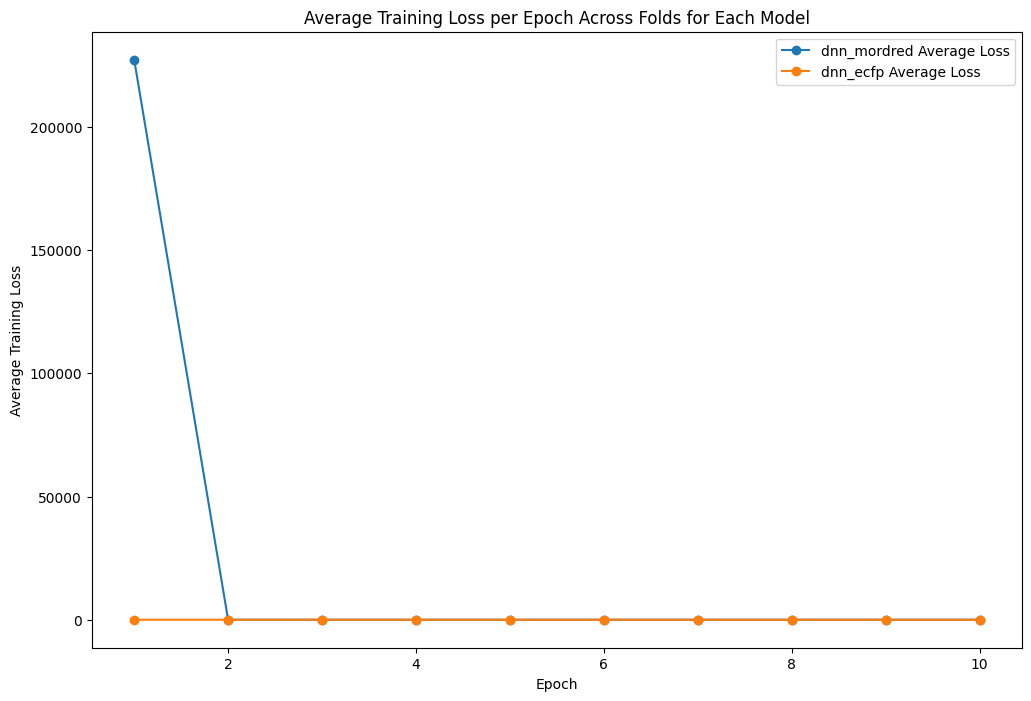

'plt.plot(history_df[\'epoch\'], history_df[\'loss\'], marker=\'o\', label=f\'{model_name} Fold {fold_idx + 1}\')\nelse:\n    print("No loss data available in loss_histories.")\n\n# Add labels and title once outside the loop\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'Training Loss\')\nplt.title(\'Training Loss per Epoch for DNN_Mordred and DNN_ECFP\')\nplt.legend()\nplt.show()\n\n\n\n\nfor model_name, losses in loss_histories.items():\n    plt.figure(figsize=(10, 5))\n    for fold_idx, history_df in enumerate(losses):\n        plt.plot(history_df[\'epoch\'], history_df[\'loss\'], marker=\'o\', label=f\'Fold {fold_idx + 1}\')\n    plt.title(f\'Loss per Epoch for {model_name}\')\n    plt.xlabel(\'Epoch\')\n    plt.ylabel(\'Loss\')\n    plt.legend()\n    plt.show()\n\n\n# Plot losses for DNN_Mordred\nif \'dnn_mordred\' in loss_histories:\n    for fold_no, history_df in enumerate(loss_histories[\'dnn_mordred\']):\n        plt.plot(history_df[\'epoch\'], history_df[\'loss\'], label=f\'DNN_Mordred

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

average_loss_histories = {}

# Plotting the losses for each model
plt.figure(figsize=(12, 8))
# Plot the losses after training
# Check if loss_histories is populated with data
if loss_histories:
    for model_name, losses in loss_histories.items():
        all_folds_losses = pd.DataFrame()

        for fold_idx, history_df in enumerate(losses):
            if history_df is not None and 'epoch' in history_df and 'loss' in history_df:
                all_folds_losses[f'fold_{fold_idx+1}'] = history_df['loss']
            else:
                print(f"Skipping {model_name} Fold {fold_idx + 1} due to missing data.")
        
        if not all_folds_losses.empty:
            average_loss_histories[model_name] = all_folds_losses.mean(axis=1)


# Plotting the average losses per epoch for each model
plt.figure(figsize=(12, 8))
for model_name, avg_losses in average_loss_histories.items():
    plt.plot(range(1, len(avg_losses) + 1), avg_losses, marker='o', label=f'{model_name} Average Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Average Training Loss per Epoch Across Folds for Each Model')
plt.legend()
plt.show()

'''plt.plot(history_df['epoch'], history_df['loss'], marker='o', label=f'{model_name} Fold {fold_idx + 1}')
else:
    print("No loss data available in loss_histories.")

# Add labels and title once outside the loop
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for DNN_Mordred and DNN_ECFP')
plt.legend()
plt.show()




for model_name, losses in loss_histories.items():
    plt.figure(figsize=(10, 5))
    for fold_idx, history_df in enumerate(losses):
        plt.plot(history_df['epoch'], history_df['loss'], marker='o', label=f'Fold {fold_idx + 1}')
    plt.title(f'Loss per Epoch for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Plot losses for DNN_Mordred
if 'dnn_mordred' in loss_histories:
    for fold_no, history_df in enumerate(loss_histories['dnn_mordred']):
        plt.plot(history_df['epoch'], history_df['loss'], label=f'DNN_Mordred Fold {fold_no+1} Loss')

# Plot losses for DNN_ECFP
if 'dnn_ecfp' in loss_histories:
    for fold_no, history_df in enumerate(loss_histories['dnn_ecfp']):
        plt.plot(history_df['epoch'], history_df['loss'], label=f'DNN_ECFP Fold {fold_no+1} Loss')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for DNN_Mordred and DNN_ECFP')
plt.legend()
plt.show() '''

# Results comparison

In [12]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

compare_benchmarks = ['dnn_mordred','dnn_ecfp'] #,'gp','gcn'] 
#compare_benchmarks = ['rf_mordred','rf_ecfp','rf_nmf_ecfp','dnn_mordred','dnn_ecfp','gp','gcn'] 

aggregated = pd.DataFrame()
    
for identity in compare_benchmarks:
    benchmark = _benchmarks[identity]
    
    folds = enumerate(kfold.get_folds(benchmark['encoding']))
    
    for fold_no, data in folds:
        fn = identity + str(fold_no) + '_' + sampling_type
        
        validation = pd.read_csv('../../data/benchmark-models/%s_predictions.csv' % fn)
        
        '''aggregated = aggregated.append({
            'benchmark': identity,
            'r2': r2_score(validation['actual_neglogld50'], validation['prediction_neglogld50']),
            'mae': mean_absolute_error(validation['actual_neglogld50'], validation['prediction_neglogld50']),
            'rmse': mean_squared_error(validation['actual_neglogld50'], validation['prediction_neglogld50'], squared=False),
            'accuracy': np.sum(validation['actual_epa'] == validation['prediction_epa']) / len(validation)
        }, ignore_index=True) '''


        #   Create a temporary DataFrame for each result
        temp_df = pd.DataFrame({
            'benchmark': [identity],
            'r2': [r2_score(validation['actual_neglogld50'], validation['prediction_neglogld50'])],
            'mae': [mean_absolute_error(validation['actual_neglogld50'], validation['prediction_neglogld50'])],
            'rmse': [mean_squared_error(validation['actual_neglogld50'], validation['prediction_neglogld50'], squared=False)],
            'accuracy': [np.sum(validation['actual_epa'] == validation['prediction_epa']) / len(validation)],
            'variance': [np.var(validation['actual_neglogld50'], ddof=1)],  # ddof=1 for sample variance
            'prediction-variance': [np.var(validation['prediction_neglogld50'], ddof=1)],  # ddof=1 for sample variance
            #'Coef-Of Variance-Actual': np.std(validation['actual_neglogld50']) / np.mean(validation['actual_neglogld50']),
            #'Coef-Of Variance-Predicted': np.std(validation['prediction_neglogld50']) / np.mean(validation['prediction_neglogld50'])

        })
        
        # Use pd.concat() to append the temp_df to the aggregated DataFrame
        aggregated = pd.concat([aggregated, temp_df], ignore_index=True)

# The DataFrame 'aggregated' now contains the results from all benchmarks.

c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

In [13]:
aggregated.pivot_table(index='benchmark', aggfunc=np.mean)

C:\Users\3742\AppData\Local\Temp\ipykernel_6748\3530873064.py:1: FutureWarning: The provided callable <function mean at 0x00000211D0314040> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  aggregated.pivot_table(index='benchmark', aggfunc=np.mean)


,accuracy,mae,prediction-variance,r2,rmse,variance
benchmark,,,,,,
dnn_ecfp,0.634782,0.389473,0.552149,0.617458,0.544737,0.777076
dnn_mordred,0.468904,0.659743,0.169379,-0.008905,0.881784,0.777076


In [15]:
#Results Using 5 Folds.
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


output_file = 'ConsolRes.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for identity in compare_benchmarks:
        actual = benchmark[identity]['actual']
        predicted = benchmark[identity]['predicted']
        
        
        unique_classes = np.sort(np.unique(np.concatenate((actual, predicted))))  # Ensure consistent class order
        cm = confusion_matrix(actual, predicted, labels=unique_classes)

        cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)
        # Add row totals
        cm_df['Row Totals'] = cm_df.sum(axis=1)

        # Add column totals
        cm_df.loc['Column Totals'] = cm_df.sum(axis=0)

        
        # Write the confusion matrix with totals to a specified sheet in the Excel file
        sheet_name = f'{identity}x_train-y-train_Confusion_Matrix'
        cm_df.to_excel(writer, sheet_name=sheet_name)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, cbar_kws={'shrink': 0.8}, 
                    xticklabels=unique_classes, yticklabels=unique_classes)
        #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=unique_classes, yticklabels=unique_classes)
        plt.title(f'Confusion Matrix for {identity} using {fold_no +1} folds')
        plt.xlabel('Predicted EPA Class')
        plt.ylabel('Actual EPA Class')
        plt.show()


# Placeholder for results
    results = []

    for identity in compare_benchmarks:
        actual = benchmark_results[identity]['actual']
        predicted = benchmark_results[identity]['predicted']
        
        unique_classes = np.sort(np.unique(np.concatenate((actual, predicted))))  # Ensure consistent class order
        cm = confusion_matrix(actual, predicted, labels=unique_classes)
        
        # Calculate precision, recall, and F1 score for each class
        precision = precision_score(actual, predicted, labels=unique_classes, average=None)
        recall = recall_score(actual, predicted, labels=unique_classes, average=None)
        f1 = f1_score(actual, predicted, labels=unique_classes, average=None)
        
        # Add each metric to the results table
        for idx, class_label in enumerate(unique_classes):
            results.append({
                'Identity': identity,
                'EPA Class': class_label,
                'Precision': precision[idx],
                'Recall': recall[idx],
                'F1 Score': f1[idx]
                })

    # Convert results to a DataFrame for easy display
    results_df = pd.DataFrame(results)

    # Display the table
    print(f'F1 Score of Kfolds = {fold_no +1} is: \n{results_df}')

    # Save to Excel if needed
    #output_file = 'F1ScoresOnMatrices_Results.xlsx'
    sheet_name = f'{identity}F1 scores '
    results_df.to_excel(writer, sheet_name = sheet_name) #output_file, index=False)

    sheet_name = f'Ers&Accs{fold_no+1}'
    aggregated_df = aggregated.pivot_table(index='benchmark', aggfunc=np.mean)
    aggregated_df.to_excel(writer, sheet_name = sheet_name)
 


IndexError: At least one sheet must be visible

In [16]:
print(fold_no)


4


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


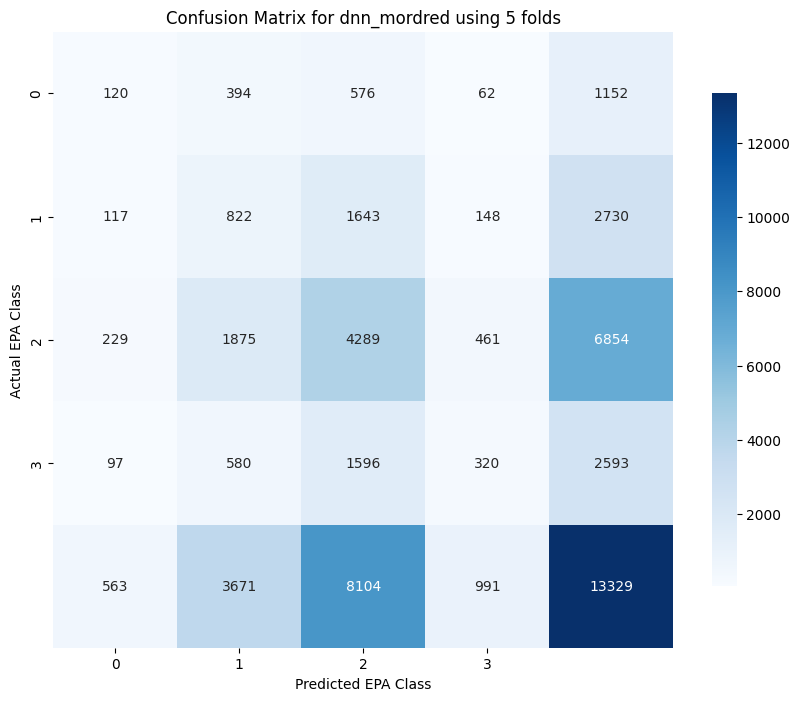

c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


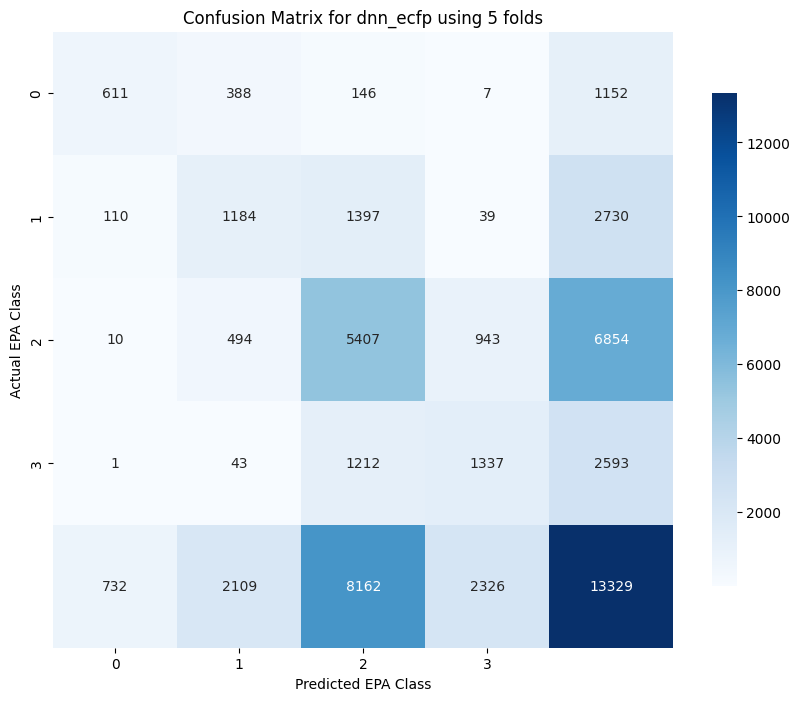

F1 Score of Kfolds = 5 is: 
      Identity  EPA Class  Precision    Recall  F1 Score
0  dnn_mordred          0   0.213144  0.104167  0.139942
1  dnn_mordred          1   0.223917  0.301099  0.256835
2  dnn_mordred          2   0.529245  0.625766  0.573472
3  dnn_mordred          3   0.322906  0.123409  0.178571
4     dnn_ecfp          0   0.834699  0.530382  0.648620
5     dnn_ecfp          1   0.561404  0.433700  0.489357
6     dnn_ecfp          2   0.662460  0.788882  0.720165
7     dnn_ecfp          3   0.574807  0.515619  0.543606


C:\Users\3742\AppData\Local\Temp\ipykernel_11556\1066928843.py:79: FutureWarning: The provided callable <function mean at 0x00000228BD7B6E80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  aggregated_df = aggregated.pivot_table(index='benchmark', aggfunc=np.mean)


In [116]:
#Results Using 5 Folds.
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


output_file = 'ConsolRes.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for identity in compare_benchmarks:
        actual = benchmark_results[identity]['actual']
        predicted = benchmark_results[identity]['predicted']
        
        
        unique_classes = np.sort(np.unique(np.concatenate((actual, predicted))))  # Ensure consistent class order
        cm = confusion_matrix(actual, predicted, labels=unique_classes)

        cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)
        # Add row totals
        cm_df['Row Totals'] = cm_df.sum(axis=1)

        # Add column totals
        cm_df.loc['Column Totals'] = cm_df.sum(axis=0)

        
        # Write the confusion matrix with totals to a specified sheet in the Excel file
        sheet_name = f'{identity}x_train-y-train_Confusion_Matrix'
        cm_df.to_excel(writer, sheet_name=sheet_name)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, cbar_kws={'shrink': 0.8}, 
                    xticklabels=unique_classes, yticklabels=unique_classes)
        #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=unique_classes, yticklabels=unique_classes)
        plt.title(f'Confusion Matrix for {identity} using {fold_no + 1} folds')
        plt.xlabel('Predicted EPA Class')
        plt.ylabel('Actual EPA Class')
        plt.show()


# Placeholder for results
    results = []

    for identity in compare_benchmarks:
        actual = benchmark_results[identity]['actual']
        predicted = benchmark_results[identity]['predicted']
        
        unique_classes = np.sort(np.unique(np.concatenate((actual, predicted))))  # Ensure consistent class order
        cm = confusion_matrix(actual, predicted, labels=unique_classes)
        
        # Calculate precision, recall, and F1 score for each class
        precision = precision_score(actual, predicted, labels=unique_classes, average=None)
        recall = recall_score(actual, predicted, labels=unique_classes, average=None)
        f1 = f1_score(actual, predicted, labels=unique_classes, average=None)
        
        # Add each metric to the results table
        for idx, class_label in enumerate(unique_classes):
            results.append({
                'Identity': identity,
                'EPA Class': class_label,
                'Precision': precision[idx],
                'Recall': recall[idx],
                'F1 Score': f1[idx]
                })

    # Convert results to a DataFrame for easy display
    results_df = pd.DataFrame(results)

    # Display the table
    print(f'F1 Score of Kfolds = {fold_no +1} is: \n{results_df}')

    # Save to Excel if needed
    #output_file = 'F1ScoresOnMatrices_Results.xlsx'
    sheet_name = f'{identity}F1 scores '
    results_df.to_excel(writer, sheet_name = sheet_name) #output_file, index=False)

    sheet_name = f'Ers&Accs{fold_no+1}'
    aggregated_df = aggregated.pivot_table(index='benchmark', aggfunc=np.mean)
    aggregated_df.to_excel(writer, sheet_name = sheet_name)
 


In [ ]:
### Examples of Visualisations 
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

compare_benchmarks = ['dnn_mordred','dnn_ecfp']
aggregated = pd.DataFrame()
#class_orders = [0, 1, 2, 3]


for identity in compare_benchmarks:
    benchmark = _benchmarks[identity]
    folds = enumerate(kfold.get_folds(benchmark['encoding']))
    
    for fold_no, data in folds:
        fn = identity + str(fold_no) + '_' + sampling_type
        validation = pd.read_csv('../../data/benchmark-models/%s_predictions.csv' % fn)

        # Forcing a Int value type
        #validation['actual_epa'] = validation['actual_epa'].astype(int)
        #validation['prediction_epa'] = validation['prediction_epa'].astype(int)
        
        # Ensure that class orders exist in the data to avoid the ValueError
        #actual_classes = set(validation['actual_epa'].unique())
        #predicted_classes = set(validation['prediction_epa'].unique())
        #relevant_classes = [cls for cls in class_orders if cls in actual_classes or cls in predicted_classes]
        
        # Create confusion matrix only for relevant classes present in the data
        #unique_classes = np.unique(validation[['actual_epa', 'prediction_epa']])
        cm = confusion_matrix(validation['actual_epa'], validation['prediction_epa'], labels=unique_classes)
        #cm = confusion_matrix((validation['actual_epa']), (validation['prediction_epa']), labels=relevant_classes)

        #plt.figure(figsize=(8, 6))
        #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {identity}, Fold {fold_no}')
        plt.xlabel('Predicted EPA Class')
        plt.ylabel('Actual EPA Class')
        plt.show()

print(validation['actual_epa'])

''' 
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

compare_benchmarks = ['dnn_mordred', 'dnn_ecfp']
aggregated = pd.DataFrame()
class_orders = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

for identity in compare_benchmarks:
    benchmark = _benchmarks[identity]
    folds = enumerate(kfold.get_folds(benchmark['encoding']))
    
    for fold_no, data in folds:
        fn = identity + str(fold_no) + '_' + sampling_type
        validation = pd.read_csv('../../data/benchmark-models/%s_predictions.csv' % fn)
        
        # Ensure that class orders exist in the data to avoid the ValueError
        actual_classes = set(validation['actual_epa'].unique())
        predicted_classes = set(validation['prediction_epa'].unique())
        relevant_classes = [cls for cls in class_orders if cls in actual_classes or cls in predicted_classes]
        
        # Create confusion matrix only for relevant classes present in the data
        cm = confusion_matrix(validation['actual_epa'], validation['prediction_epa'], labels=relevant_classes)
        
        # Plot the confusion matrix with consistent labels
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=relevant_classes, yticklabels=relevant_classes)
   '''
